# Perfect meal

By definition, there should be one (or more) diets that are "perfect" based on the following criteria:
- Minimize greenhouse gas emissions
- Satisfy (or exceed) all nutritional needs

Let's try to (playfully, but somewhat realistically) answer that question!

Let's start by importing the modules we'll need.

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
from scipy.optimize import linprog
from tqdm import tqdm

The first step is to find some data relating green house gas emissions to different food items. This was surpsingly hard to find in a useable format and with a large enough number of items...
The best source I could locate was from [this paper](https://www.nature.com/articles/s41597-021-00909-8), which introduces the SU-EATABLE LIFE database.

The database is an excel file which I copied under `data/ghg_emissions.xlsx`. We can load it using pandas directly. We want the `SEL CF for users` sheet.

In [3]:
food_ghg = pd.read_excel("data/ghg_emissions.xlsx", sheet_name="SEL CF for users", index_col=0)
print(f"Size of \"database\" {food_ghg.shape}")

Size of "database" (324, 8)


It looks like there are 324 food items in this database, which is not very large; but it's a good start. Let's take a look at the data.

In [4]:
food_ghg.iloc[0]

Food commodity ITEM                                     BEER IN CAN
Carbon Footprint kg CO2eq/kg or l of food ITEM                0.693
Uncertainty    low (L) high (H)                                   L
Suggested CF value                                          OK item
Food commodity TYPOLOGY                                        BEER
Carbon Footprint g CO2eq/g o cc of food TYPOLOGY               0.69
Food commodity sub-TYPOLOGY                                       -
Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY              -
Name: AGRICULTURAL PROCESSED, dtype: object

Looks like we have what we need (although I doubt beer will be part of the ideal diet...but let's keep an open mind, shall we?). Let's clean it up by renaming the columns we'll need to something more manageable and dropping the rest. Let's also add a column with the type of each item, where type can be meat, fish and vegetarian.

In [5]:
food_ghg = (
    food_ghg[
        [
            "Food commodity ITEM",
            "Carbon Footprint kg CO2eq/kg or l of food ITEM",
            "Food commodity TYPOLOGY",
        ]
    ]
    .reset_index(drop=True)
    .rename(
        columns={
            "Food commodity ITEM": "food",
            "Carbon Footprint kg CO2eq/kg or l of food ITEM": "ghg",
            "Food commodity TYPOLOGY": "type",
        }
    )
)

# Cleanup the food column which has asterixes etc. This line is doing a lot...
food_ghg["food"] = food_ghg["food"].apply(
    lambda x: " ".join(
        [w for w in x.translate(str.maketrans("", "", "()*'")).lower().split() if len(w) > 1]
    )
)

food_ghg["type"] = (
    food_ghg["type"]
    .apply(str.lower)
    .apply(lambda x: "meat" if "meat" in x else "fish" if "fish" in x else "vegetarian")
)

Let's see how that looks:

In [6]:
food_ghg.iloc[0:10]

,food,ghg,type
0,beer in can,0.69300,vegetarian
1,beer in glass,0.96050,vegetarian
2,beer modular can,0.53060,vegetarian
3,chocolate or cream filled cookies,1.53300,vegetarian
4,simple cookies,1.39075,vegetarian
5,mineral water,0.49100,vegetarian
6,bread multicereal,0.70300,vegetarian
7,bread plain,0.88500,vegetarian
8,bread whole,0.77200,vegetarian
9,bread frozen,1.31000,vegetarian


Much better!

Unfortunately the matching I'll do in a little bit doesn't work so well. So I'll manually correct some of the entries now. This is very dirty. It would be much better to solve the matching problem. Let's call that an exercise for the reader.

In [7]:
to_exlcude = {
    "asiago",
    "coffee drip",
    "coffee ground",
    "coffee parchment",
    "coffee soluble powder",
    "cornflakes",
    "fig juice",
    "green bean fresh",
    "hake",
    "ketchup",
    "mineral water",
    "pecorino",
    "stracchino",
    "swede",
}

to_swap = {
    "almond milk": "beverages, almond milk, unsweetened, shelf stable",
    "apple": "apples, raw, golden delicious, with skin",
    "beer in can": "alcoholic beverage, beer, light",
    "beer in glass": "alcoholic beverage, beer, light",
    "beer modular can": "alcoholic beverage, beer, light",
    "buffalo bone free meat": "game meat, buffalo, water, cooked, roasted",
    "eel": "Fish, eel, mixed species, raw",
    "espresso": "beverages, coffee, brewed, espresso, restaurant-prepared",
    "grapes": "grapes, red or green (European type, such as Thompson seedless), raw",
    "oats": "cereals, QUAKER, Quick Oats, Dry",
    "onion": "onions, raw",
    "parmigiano reggiano": "Cheese, parmesan, grated",
    "pear juice": "babyfood, juice, pear",
    "sardine": "fish, sardine, Atlantic, canned in oil, drained solids with bone",
    "squid": "mollusks, squid, mixed species, cooked, fried",
    "tuna in can": "fish, tuna, white, canned in oil, drained solids",
    "vanilla": "vanilla extract",
    "wine red": "alcoholic beverage, wine, table, red",
}

food_ghg = food_ghg[~food_ghg["food"].isin(to_exlcude)]
food_ghg["food"] = food_ghg["food"].replace(to_swap)

Next we need detailed nutritonal information for each food item. Luckily there was much more data available for this part. I went with [Food Data Central](https://fdc.nal.usda.gov/download-datasets.html), which lets you download all of their data as a single `.json` file. Nice! I went with the `SR Legacy` version because it seemed to give me the best matches when using the search bar on their website.

In [8]:
with open("data/food_nutrition.json") as f:
    all_nutrition_db = json.load(f)["SRLegacyFoods"]

print(f"Size of \"database\" {len(all_nutrition_db)}")

Size of "database" 7793


This has 7793 items. That's much bigger than our green house gas database. Feel free to explore all the stuff that's in there. What we need is under `foodNutrients`. Let's extract that and put it in a dataframe.


In [9]:
all_nutrition_db[0]["foodNutrients"][0]

{'type': 'FoodNutrient',
 'id': 1283674,
 'nutrient': {'id': 1003,
  'number': '203',
  'name': 'Protein',
  'rank': 600,
  'unitName': 'g'},
 'dataPoints': 1,
 'foodNutrientDerivation': {'code': 'MA',
  'description': 'Manufacturer supplied(industry or trade association), Analytical data, incomplete documentation',
  'foodNutrientSource': {'id': 9,
   'code': '12',
   'description': "Manufacturer's analytical; partial documentation"}},
 'amount': 5.88}

We now face our first challenge. We need to match each entry in our greenhouse gas emission list with the corresponding (or closest) food in the nutritional database. Unfortunately, the names of these foods can be quite different between the two sources.

One way to solve this is by using the Levenshtein distance between the names of the foods. This allows us to compute the "distance" between two strings. We can then match the food items by finding the closest match in the nutritional database for each item in the greenhouse gas database.

In [10]:
all_entries = []
all_nutritional_db_food_names = np.hstack([x["description"].lower() for x in all_nutrition_db])
for idx, row in tqdm(food_ghg.iterrows(), total=food_ghg.shape[0]):
    food_name = row["food"]

    # I seem to have had better success with this double matching approach.
    # We first get the 5 top matches using partial token sort ratio, which is more forgiving
    # Then we pick the best match from those 5 using ratio, which is stricter
    matches = [
        m[0]
        for m in process.extract(
            food_name, all_nutritional_db_food_names, scorer=fuzz.partial_token_sort_ratio
        )
    ]
    if len(matches) > 0:
        best_match, best_score = process.extract(food_name, matches, scorer=fuzz.ratio)[0]
        # print(f"Found {len(matches)} matches for {item}: {matches}")
        # print(f"---best match with score {best_score}: {best_match}")

    if best_match is None:
        continue

    idx = np.where(all_nutritional_db_food_names == best_match)[0][0]
    nutrients = {
        nut["nutrient"]["name"]: {
            "amount": nut["amount"],
            "unit": nut["nutrient"]["unitName"],
        }
        for nut in all_nutrition_db[idx]["foodNutrients"]
    }
    entry = {
        "name": food_name,
        "name_match": best_match,
        "match_score": best_score,
        "nutrients": nutrients,
        "ghg": row["ghg"],
        "portion_ghg": row["ghg"] * 0.1,  # 100g portions
        "type": row["type"],
    }
    all_entries.append(entry)

df_entries = pd.DataFrame(all_entries)

100%|██████████| 310/310 [00:29<00:00, 10.54it/s]


Great! We now have a dictionary with all the information we need. For each food item, we have the greenhouse gas emission and the nutritional information. Let's take a look:

In [11]:
df_entries.iloc[7]

name                                                 bread whole
name_match                                    bread, white wheat
match_score                                                   62
nutrients      {'Total lipid (fat)': {'amount': 2.15, 'unit':...
ghg                                                        0.772
portion_ghg                                               0.0772
type                                                  vegetarian
Name: 7, dtype: object

Now we just need the last piece of the puzzle: what is the ideal nutritional intake we should be aiming for?

I found a great calculator [here](https://www.nal.usda.gov/human-nutrition-and-food-safety/dri-calculator/results).

I plugged in a 30 year old average american male, (1.75m, 88.9kg, "low active") and got the following results (each entry is a tuple with min and max daily amounts):


In [13]:
target_nutrients = {
    # Macro nutrients
    "Energy": (2996, 3500),
    # "Water": (3700, 4000),
    "Carbohydrate, by difference": (337, 487),
    "Fiber, total dietary": (38, None),
    "Protein": (71, None),
    "Total lipid (fat)": (67, 117),
    # Vitamins
    "Vitamin A, RAE": (900, 3000),
    "Vitamin C, total ascorbic acid": (90, 2000),
    "Vitamin D (D2 + D3)": (15, 100),
    "Vitamin B-6": (1.3, 100),
    "Vitamin E (alpha-tocopherol)": (15, 1000),
    "Vitamin K (phylloquinone)": (120, None),
    "Thiamin": (1.2, None),
    "Vitamin B-12": (2.4, None),
    "Riboflavin": (1.3, None),
    "Folate, total": (400, 1000),
    "Niacin": (16, 35),
    "Choline, total": (550, 3500),
    "Pantothenic acid": (5, None),
    # "Biotin": (30, None),
    # Minerals
    "Calcium, Ca": (1000, 2500),
    # "Chloride, Cl": (2300, 3600),
    # "Chromium, Cr": (35, None),
    "Copper, Cu": (0.9, 10),
    "Fluoride, F": (4, 10),
    # "Iodine, I": (150, 1100),
    "Iron, Fe": (8, 45),
    "Magnesium, Mg": (400, None),
    "Manganese, Mn": (2.3, 11),
    # "Molybdenum, Mo": (45, 2000),
    "Phosphorus, P": (700, 4000),
    "Potassium, K": (3400, None),
    "Selenium, Se": (55, 400),
    "Sodium, Na": (1500, None),
    "Zinc, Zn": (11, 40),
}

We now have all the data we need. If we look at this problem carefully, we'll notice that it's a minimization problem with constraints, which we can solve using linear programming. We want to minimize the sum of greenhouse gas emissions of our diet while satisfying the minimum and maximum constraints imposed by the nutritional intake targets.

The formula we are trying to mimimize is:
`ghg_sum = x1 ghg_food_1 + x2 ghg_food_2 + ... + xn ghg_food_n`

Where `x1, x2, ..., xn` are the amounts of each food item in our diet and `ghg_food_1, ghg_food_2, ..., ghg_food_n` are the greenhouse gas emissions of each food item.

Our constraints are of the form:
`min_nutrient_1 <= x1 nutrient_1 + x2 nutrient_1 + ... + xn nutrient_1`
`min_nutrient_2 <= x1 nutrient_2 + x2 nutrient_2 + ... + xn nutrient_2`
...
`min_nutrient_n <= x1 nutrient_n + x2 nutrient_n + ... + xn nutrient_n`

Where `nutrient_1, nutrient_2, ..., nutrient_n` are the nutrients we are trying to satisfy.

We also have maximum amounts for some nutrients:
`x1 nutrient_1 + x2 nutrient_1 + ... + xn nutrient_1 <= max_nutrient_1`

We can solve this using the `scipy.optimize.linprog` function.

We'll look at this a few ways, so let's make a function:

In [14]:
def solve(
    df_entries, target_nutrients, include_meat=True, include_fish=True, include_vegetarian=True, maximize = False
):
    c = df_entries["portion_ghg"].to_numpy()
    if maximize:
        c = -c

    # Extract nutrional values as a matrix
    all_nut_values = []
    for _, row in df_entries.iterrows():
        all_nut_values.append(
            [
                row["nutrients"][k]["amount"] if k in row["nutrients"] else 0
                for k in target_nutrients.keys()
            ]
        )
    all_nut_values = np.array(all_nut_values)

    # Minimum nutritional values constraints
    A_ub = -all_nut_values.T
    b_ub = -np.array(list(target_nutrients.values()))[:,0]
    
    # Maximum nutritional values constraints
    for idx, max_amount in enumerate(np.array(list(target_nutrients.values()))[:,1]):
        if max_amount is None:
            continue
        A_ub = np.vstack((A_ub, all_nut_values.T[idx]))
        b_ub = np.hstack((b_ub, max_amount))

    A_eq = None
    b_eq = None
    if not (include_meat & include_fish & include_vegetarian):
        exclude = set()
        if not include_meat:
            exclude.add("meat")
        if not include_fish:
            exclude.add("fish")
        if not include_vegetarian:
            exclude.add("vegetarian")
        A_eq = [[1 if e["type"] in exclude else 0 for e in all_entries]]
        b_eq = [0]

    return linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, None))

In [15]:
def print_best_diet(results, maximize = False):
    if maximize:
        results.fun = -results.fun
    actual_nutrients = {k: 0 for k in target_nutrients.keys()}
    print(f"The {'worst' if maximize else 'optimal'} diet leads to a carbon footprint of: {results.fun:.4f} kg CO2e, it consists of:")
    sort_keys = np.argsort(results.x)[::-1]
    for idx, q in enumerate(results.x[sort_keys]):
        if q > 0:
            print(
                f"- {q*100:.2f} grams of"
                f" {all_entries[sort_keys[idx]]['name']} ({all_entries[sort_keys[idx]]['name_match']})"
            )
            for nutrient in target_nutrients.keys():
                if nutrient not in all_entries[sort_keys[idx]]["nutrients"]:
                    continue
                actual_nutrients[nutrient] += (
                    q * all_entries[sort_keys[idx]]["nutrients"][nutrient]["amount"]
                )

Let's solve for x!

The optimal diet leads to a carbon footprint of: 0.3373 kg CO2e, it consists of:
- 909.63 grams of beans in can (beans, baked, canned, no salt added)
- 120.15 grams of tomato (tomatoes, sun-dried)
- 108.17 grams of carrot (carrots, baby, raw)
- 106.39 grams of mixed nuts (nuts, mixed nuts, dry roasted, with peanuts, with salt added)
- 59.52 grams of mackerel (fish, mackerel, salted)
- 40.44 grams of rye (rye grain)
- 34.91 grams of bread whole (bread, white wheat)
- 7.65 grams of lemon (lemon peel, raw)
- 5.68 grams of spinach (spinach, raw)
- 3.81 grams of alcoholic beverage, wine, table, red (alcoholic beverage, wine, table, red)


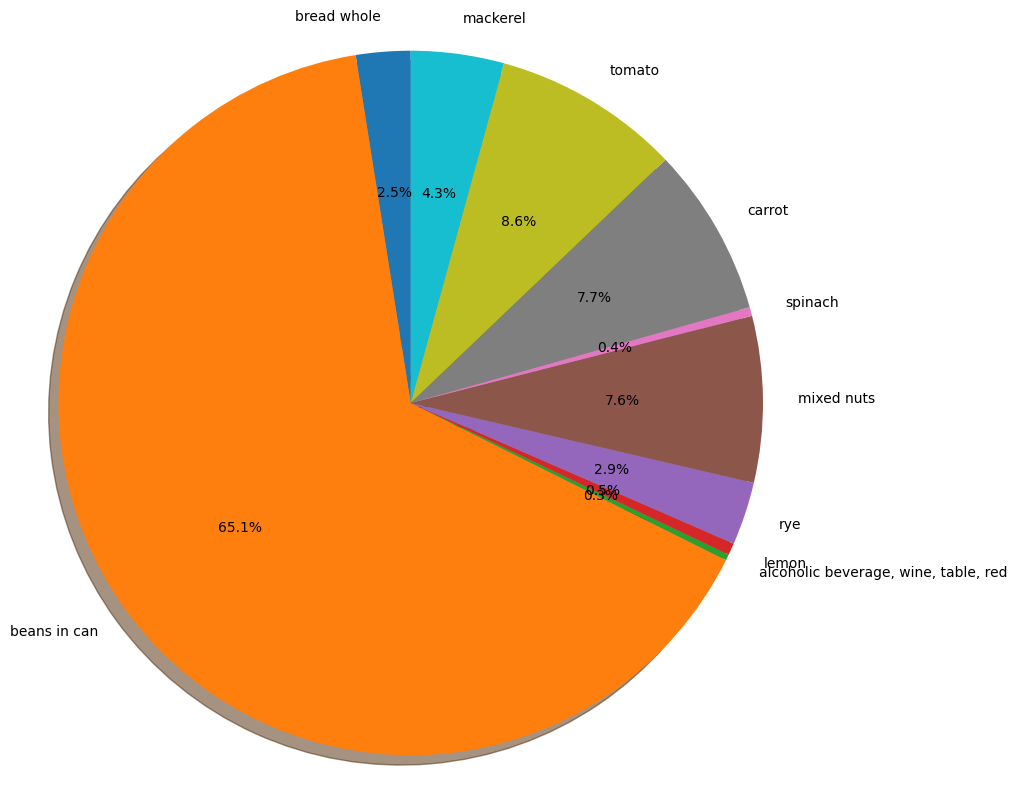

In [16]:
results = solve(
    df_entries, 
    target_nutrients,
    include_meat=True,
    include_fish=True,
    include_vegetarian=True,
)
print_best_diet(results)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(
    results.x[results.x > 0],
    labels=[all_entries[idx]["name"] for idx in np.where(results.x > 0)[0]],
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
ax.axis("equal")
plt.show()

The lowest CO2e daily value is quite low (~0.3kg). That's quite a bit lower than what the vegan diet (0.8kg) and the vegetarian diet (1.7kg) are estimated to be, which are both considerd to be quite environmental friendly. 

Afrouzi, H. N., Ahmed, J., Siddique, B. M., Khairuddin, N., & Hassan, A. (2023). A comprehensive review on carbon footprint of regular diet and ways to improving lowered emissions. Results in Engineering, 101054.

Scarborough, P., Appleby, P. N., Mizdrak, A., Briggs, A. D., Travis, R. C., Bradbury, K. E., & Key, T. J. (2014). Dietary greenhouse gas emissions of meat-eaters, fish-eaters, vegetarians and vegans in the UK. Climatic change, 125(2), 179-192.

Another interesting observation is that despite all the pittfalls of this simple analysis, the results are actually quite reasonable. This seems like a viable diet!

Perhaps more interestingly, this low CO2e diet is not vegan or vegetarian, but rather pescatarian, as it includes mackerel. That doesn't disprove the finding that vegan and vegetarian diets are, on average and as practically implemented, more environmentally friendly than omnivorous diets. It does, however, seemingly show that there are ways to eat fish and still have a very low environmental impact.

Let's see what the optiaml diet is if we force a vegetarian diet:

The optimal diet leads to a carbon footprint of: 0.9297 kg CO2e, it consists of:
- 1014.04 grams of beans in can (beans, baked, canned, no salt added)
- 801.32 grams of beverages, almond milk, unsweetened, shelf stable (beverages, almond milk, unsweetened, shelf stable)
- 191.28 grams of soy milk (silk chocolate, soymilk)
- 127.89 grams of tomato (tomatoes, sun-dried)
- 111.24 grams of carrot (carrots, baby, raw)
- 91.99 grams of mushroom (mushrooms, morel, raw)
- 77.24 grams of mixed nuts (nuts, mixed nuts, dry roasted, with peanuts, with salt added)
- 9.46 grams of yeast compressed (yeast extract spread)
- 5.36 grams of spinach (spinach, raw)
- 5.27 grams of soybean oil (oil, soybean lecithin)
- 4.23 grams of cauliflower (cauliflower, green, raw)
- 3.81 grams of alcoholic beverage, wine, table, red (alcoholic beverage, wine, table, red)
- 2.97 grams of coconut milk (oil, coconut)


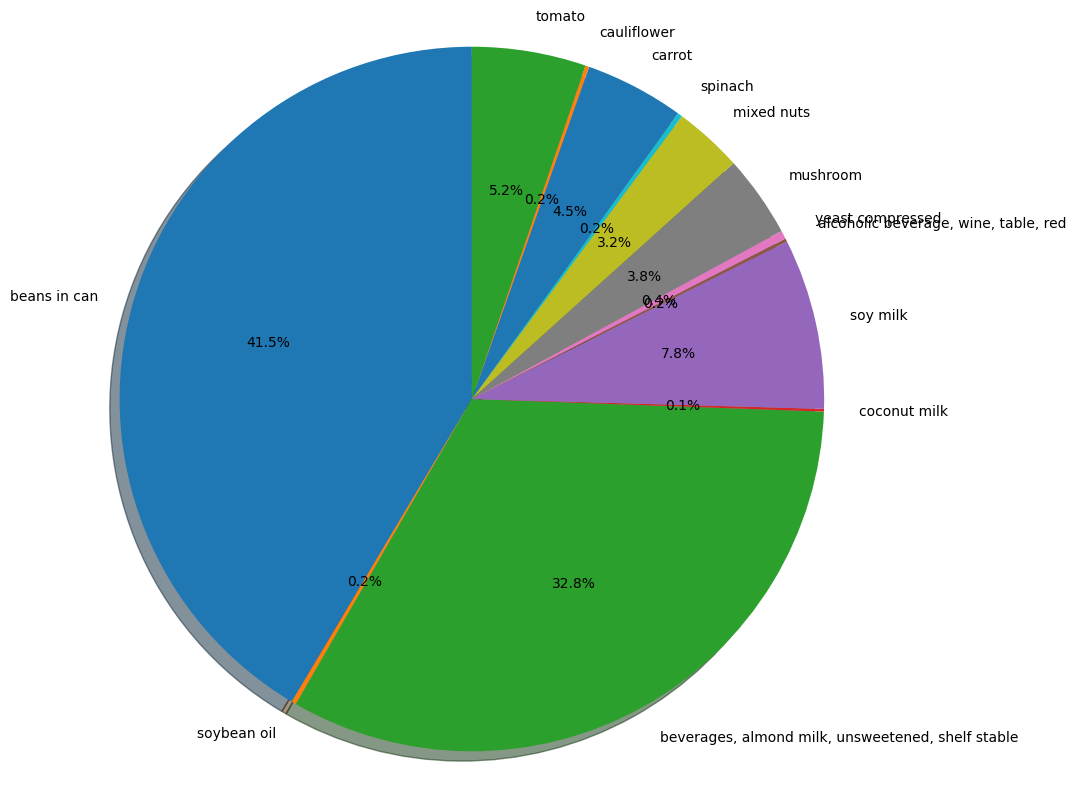

In [17]:
results = solve(
    df_entries, 
    target_nutrients,
    include_meat=False,
    include_fish=False,
    include_vegetarian=True,
)
print_best_diet(results)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(
    results.x[results.x > 0],
    labels=[all_entries[idx]["name"] for idx in np.where(results.x > 0)[0]],
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
ax.axis("equal")
plt.show()

Which is almost three times higher than the lowest diet we found previously!

This is also in line with the greenhouse gas emission estimates for vegetarian diets, confirming that our simple approach here yields plausible results.

We can also use the same approach to look for the worst possible diet by changing the minimization to a mazimization problem. This will work because we have both upper and lower bounds on nutritents (otherwise the maximization problem would be unbounded).

In [18]:
results = solve(
    df_entries, 
    target_nutrients,
    include_meat=True,
    include_fish=True,
    include_vegetarian=True,
    maximize=True
)
print_best_diet(results, maximize=True)

The worst diet leads to a carbon footprint of: 52.5168 kg CO2e, it consists of:
- 2796.83 grams of kiwi juice (beverages, kiwi strawberry juice drink)
- 693.94 grams of lettuce (lettuce, red leaf, raw)
- 525.10 grams of buffalo milk (milk, indian buffalo, fluid)
- 472.80 grams of game meat, buffalo, water, cooked, roasted (game meat, buffalo, water, cooked, roasted)
- 387.24 grams of beverages, almond milk, unsweetened, shelf stable (beverages, almond milk, unsweetened, shelf stable)
- 273.57 grams of lemon (lemon peel, raw)
- 181.34 grams of megrim (pomegranate juice, bottled)
- 172.11 grams of cow milk (milk, low sodium, fluid)
- 147.90 grams of eggs (eggs, scrambled, frozen mixture)
- 25.22 grams of carp (fish, carp, raw)
- 16.97 grams of apple juice (beverages, grape juice drink, canned)
- 7.79 grams of plain crackers (crackers, rye, wafers, plain)


A whooping 52.5 kg of CO2e per day! And no surprise here, this has a lot of red meat and dairy.

We can do the same with a vegetarian diet:

In [19]:
results = solve(
    df_entries, 
    target_nutrients,
    include_meat=False,
    include_fish=False,
    include_vegetarian=True,
    maximize=True
)
print_best_diet(results, maximize=True)

The worst diet leads to a carbon footprint of: 18.7939 kg CO2e, it consists of:
- 3228.24 grams of zucchini (squash, zucchini, baby, raw)
- 2244.31 grams of kiwi juice (beverages, kiwi strawberry juice drink)
- 769.23 grams of cucumber (cucumber, with peel, raw)
- 572.74 grams of eggs (eggs, scrambled, frozen mixture)
- 482.30 grams of lettuce (lettuce, red leaf, raw)
- 428.65 grams of beverages, almond milk, unsweetened, shelf stable (beverages, almond milk, unsweetened, shelf stable)
- 367.58 grams of buffalo milk (milk, indian buffalo, fluid)
- 168.18 grams of beverages, coffee, brewed, espresso, restaurant-prepared (beverages, coffee, brewed, espresso, restaurant-prepared)
- 28.63 grams of cow milk (milk, low sodium, fluid)
- 0.63 grams of mushroom (mushrooms, morel, raw)


That's not quite as bad, confirming that it's harder to do as much harm (from a CO2 perspective) with a vegetarian diet. Additionally, most of the CO2 here comes from the milk.

Still, it's interesting (and perhaps intuively very unsurprising) that there is a very wide range of CO2 emissions possible with any diet, depending on the specific foods chosen.

In [20]:
pd.set_option('display.max_rows', 500)
df_entries[["name", "name_match", "portion_ghg"]]


,name,name_match,portion_ghg
0,"alcoholic beverage, beer, light","alcoholic beverage, beer, light",0.069300
1,"alcoholic beverage, beer, light","alcoholic beverage, beer, light",0.096050
2,"alcoholic beverage, beer, light","alcoholic beverage, beer, light",0.053060
3,chocolate or cream filled cookies,"cookies, chocolate sandwich, with creme fillin...",0.153300
4,simple cookies,"cookies, fig bars",0.139075
5,bread multicereal,"bread, rye",0.070300
6,bread plain,"bread, sticks, plain",0.088500
7,bread whole,"bread, white wheat",0.077200
8,bread frozen,"garlic bread, frozen",0.131000
9,dark chocolate,"candies, special dark chocolate bar",0.271000


In conclusion, I think the message is quite clear: eat more beans :)